In [1]:
from scipy.optimize import leastsq,curve_fit
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
import math as math
from scipy.optimize import curve_fit

Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [466]:
def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return distances

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)


def var_y(x,sigma_s0,sigma_b,cov_b_s0,s0_est,b_est):
    r0 = 300
    gamma = (x/r0)**(-2*b_est)     
    return (gamma*(sigma_s0**2 + (s0_est*np.log(x/r0)*sigma_b)**2 - 2*s0_est*np.log(x/r0)*cov_b_s0))

def powerlaw(r, s0, b):  # r0 no es variable aleatoria
    r0 = 300
    return s0*(r/r0)**(-b)

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point
    
    
def evento(poligono,pointsx,pointsy,evento,pwl,angulo):
    #Genero el punto random.
    random_point = in_hex(poligono)
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    
    """
    Aplico power law

    """
    
    params = [35,2.1]
    r0 = 300 #metros 
    s0 = 35 #VEM
    b = 2.1
    r = np.asarray(distancias)
    

    y = powerlaw(r,s0,b)
    sigma = np.sqrt(y)
    
    
    #Hago el ajuste y defino la semilla inicial
    y_random = np.random.normal(y,sigma,size = len(y))  #signal    
    params=[35, 2.1]


    popt, pcov = curve_fit(powerlaw, distancias, y_random, p0=params)
    
    s0_est = popt[0]
    b_est = popt[1]
    
    x =  np.linspace(min(r),max(r),10000)
    y = powerlaw(x,s0_est,b_est)
    
    
    sigma_s0 = np.sqrt(pcov[0,0])
    sigma_b = np.sqrt(pcov[1,1])
    cov_b_s0 = pcov[0,1]
    
    var_simulacion = var_y(x,sigma_s0,sigma_b,cov_b_s0,s0_est,b_est)


#    plt.plot(x,var_simulacion/y)
 #   plt.ylabel('Error relativo')
  #  plt.xlabel('Distancia[m]')
    
    
    if pwl == True:
        plt.figure(figsize=(7,7))
        plt.title('Ajuste del evento',size = 20)
        plt.grid(linestyle='--')

        plt.ylabel('y(x)',size = 16)
        plt.xlabel('x',size = 16)
        
        plt.plot(x,y, label='ajuste pwl')
        plt.errorbar(x,y,yerr = var_simulacion,alpha=0.2)
        
        plt.plot(distancias,y_random,'o',color = 'orange')
        plt.errorbar(distancias,y_random,yerr =np.sqrt(y_random) ,ls = 'none',ecolor='black')
        
        plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
        
    #Opcional visualizar el ajuste del evento    
    if evento == True:
        plt.figure(figsize=(8,8))
        polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
        plt.gca().add_patch(polygon)
        plt.xlim(-600,600)
        plt.ylim(-600,600)
        plt.scatter(centro[0],centro[1],s = 100,c ='black')
        plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
        plt.scatter(pointsx,pointsy,s = 100,c = 'black')
        plt.grid(linestyle='--')
        plt.show()
        
    cov = pcov
    coeffcorr = cov[0,1]/(sigma_b*sigma_s0)
    print('Distancias:', distancias)
    print('Estimación de s0:', np.round(s0_est,2),'±',np.round(sigma_s0,2))
    print('Estimación de b_est:', np.round(b_est,2),'±',np.round(sigma_b,2))
    print('Coeff corr', coeffcorr)
    print('sigma_b', sigma_b)
    print('sigma_s0',sigma_s0)
    print('cov_s0_b', cov_b_s0)
    return(np.min(var_simulacion))

In [425]:
poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
random_point = in_hex(poligono)
centro = (0,0)

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

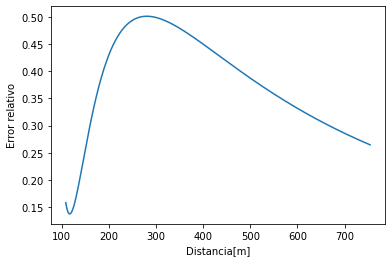

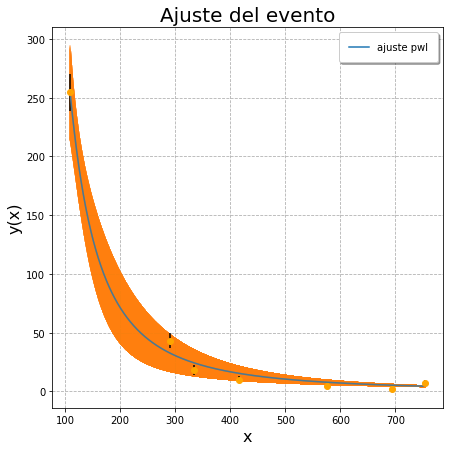

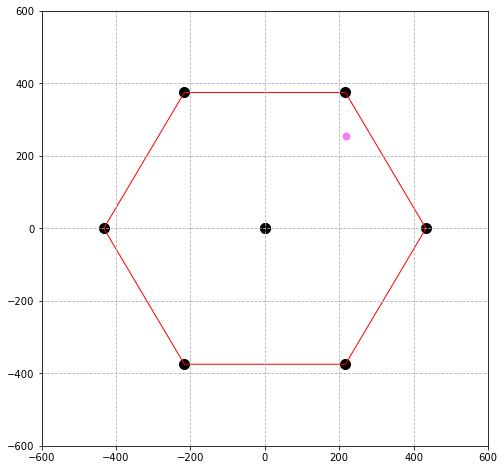

Distancias: [754.17509202 575.7514343  289.68594005 108.81830094 415.49880537
 694.71808681 333.24910566]
Estimación de s0: 30.43 ± 3.9
Estimación de b_est: 2.1 ± 0.13
Coeff corr -0.9814440841581896
sigma_b 0.12808996322469027
sigma_s0 3.895833957317246
cov_s0_b -0.48975750662990414


In [463]:
test = evento(poligono,pointsx,pointsy,True,True,30) 